In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def func_state_transition(self, nu, omega, time, pose): #追加（IdealRobotからコピー）
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(nu/time) + ns[1]*math.sqrt(omega/time)
        pomega = omega + ns[2]*math.sqrt(nu/time) + ns[3]*math.sqrt(omega/time)
        self.pose = self.func_state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_vars): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_vars
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
    def decision(self):        ###MclAgent5
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[ 0.0182952   0.00030199  0.03301044]
[ 0.01939104  0.00020955  0.02161184]
[ 0.01917613  0.0001199   0.01250447]
[ 0.01628517  0.0001098   0.01348395]
[ 0.0219284   0.00020902  0.01906353]
[ 0.01567872  0.00013814  0.01762051]
[ 0.02618198  0.0002994   0.02286957]
[  2.22247136e-02   9.91606713e-05   8.92340077e-03]
[  1.93569777e-02   6.30266467e-05   6.51201082e-03]
[  1.60448314e-02   6.53952160e-05   8.15151646e-03]
[ 0.02189772  0.0002679   0.02446728]
[ 0.02024829  0.00017034  0.01682455]
[ 0.01964293  0.00020091  0.02045595]
[ 0.02211482  0.00017661  0.01597185]
[ 0.01792137  0.00015648  0.01746293]
[ 0.0191236   0.00022396  0.02342162]
[ 0.02130478  0.00032533  0.03053835]
[ 0.0211036   0.00016626  0.01575668]
[ 0.01901297  0.00012217  0.01285061]
[ 0.01923523  0.00015185  0.01578841]
[ 0.01640423  0.0001376   0.01677592]
[ 0.02057249  0.00024571  0.0238859 ]
[  1.84081440e-02   7.88201982e-05   8.56357015e-03]
[ 0.02026212  0.00026264  0.02592268]
[ 0.02286506  0.0002842   0.

<IPython.core.display.Javascript object>


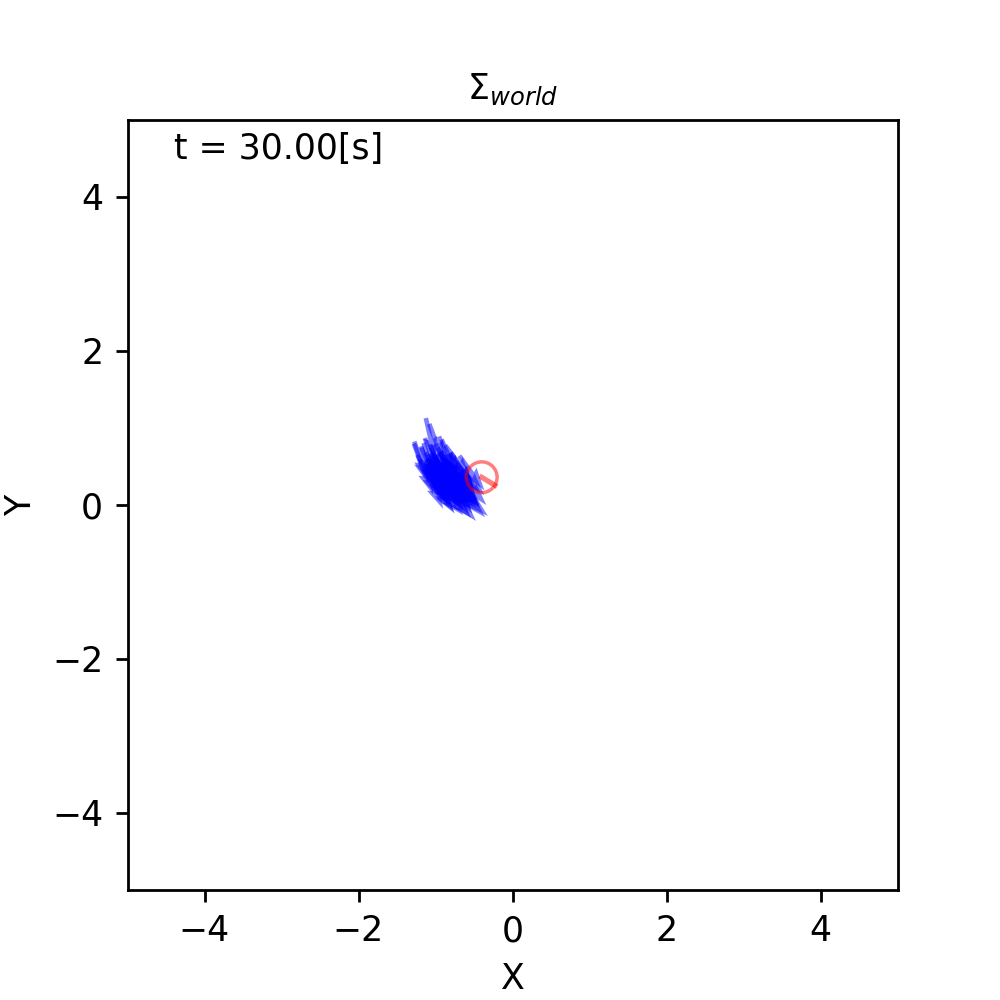

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()